In [18]:
from math import log, sqrt, pi, exp
import math
from scipy.stats import norm
from datetime import datetime, date
import numpy as np
import pandas as pd
from pandas import DataFrame
from datetime import datetime
from arch.__future__ import reindexing
import pmdarima
import arch
import matplotlib.pyplot as plt 
import arch
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from arch.univariate import HARX

# Black Scholes Formulas

In [2]:
# Just as a reminder, in black scholes the following variables signify:
# S = spot price
# K = strike price
# T = time to expiry 
# r = risk free rate
# sigma = volatility

#Functions d1 and d2 calculate the probability of receiving the stock at the expiration of the option as well a the risk-adjusted probability that the option will be exercised
def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)

#Implementing black scholes using above functions
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))
  
def bs_put(S,K,T,r,sigma):
    return K*exp(-r*T)-S+bs_call(S,K,T,r,sigma)


#Implied volatility functions
def call_implied_volatility(Price, S, K, T, r):
    sigma = 0.001
    while sigma < 1:
        Price_implied = S * \
            norm.cdf(d1(S, K, T, r, sigma))-K*exp(-r*T) * \
            norm.cdf(d2(S, K, T, r, sigma))
        if Price-(Price_implied) < 0.001:
            return sigma
        sigma += 0.001
    return "Not Found"

def put_implied_volatility(Price, S, K, T, r):
    sigma = 0.001
    while sigma < 1:
        Price_implied = K*exp(-r*T)-S+bs_call(S, K, T, r, sigma)
        if Price-(Price_implied) < 0.001:
            return sigma
        sigma += 0.001
    return "Not Found"

#Calculating option greeks
def call_delta(S,K,T,r,sigma):
    return norm.cdf(d1(S,K,T,r,sigma))
def call_gamma(S,K,T,r,sigma):
    return norm.pdf(d1(S,K,T,r,sigma))/(S*sigma*sqrt(T))
def call_vega(S,K,T,r,sigma):
    return 0.01*(S*norm.pdf(d1(S,K,T,r,sigma))*sqrt(T))
def call_theta(S,K,T,r,sigma):
    return 0.01*(-(S*norm.pdf(d1(S,K,T,r,sigma))*sigma)/(2*sqrt(T)) - r*K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma)))
def call_rho(S,K,T,r,sigma):
    return 0.01*(K*T*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma)))
    
def put_delta(S,K,T,r,sigma):
    return -norm.cdf(-d1(S,K,T,r,sigma))
def put_gamma(S,K,T,r,sigma):
    return norm.pdf(d1(S,K,T,r,sigma))/(S*sigma*sqrt(T))
def put_vega(S,K,T,r,sigma):
    return 0.01*(S*norm.pdf(d1(S,K,T,r,sigma))*sqrt(T))
def put_theta(S,K,T,r,sigma):
    return 0.01*(-(S*norm.pdf(d1(S,K,T,r,sigma))*sigma)/(2*sqrt(T)) + r*K*exp(-r*T)*norm.cdf(-d2(S,K,T,r,sigma)))
def put_rho(S,K,T,r,sigma):
    return 0.01*(-K*T*exp(-r*T)*norm.cdf(-d2(S,K,T,r,sigma)))

# Input Data

In [3]:
#Daily SPX Data From Bloomberg
df = pd.read_excel("5Y_SPX_Daily_Data.xlsx", "Sheet1") 
df

,Date,Open,High,Low,Close
0,2016-08-29,2170.19,2183.48,2170.19,2180.38
1,2016-08-30,2179.45,2182.27,2170.41,2176.12
2,2016-08-31,2173.56,2173.79,2161.35,2170.95
3,2016-09-01,2171.33,2173.56,2157.09,2170.86
4,2016-09-02,2177.49,2184.87,2173.59,2179.98
...,...,...,...,...,...
1253,2021-08-20,4410.56,4444.35,4406.80,4441.67
1254,2021-08-23,4450.29,4489.88,4450.29,4479.53
1255,2021-08-24,4484.40,4492.81,4482.28,4486.23
1256,2021-08-25,4490.45,4501.71,4485.66,4496.19


In [10]:
#Aug 29th 2016 to April 29th 2021 will be used as train data for the model
SPX_dates = df['Date'].to_list()
SPX_dates = [SPX_dates[i].to_pydatetime() for i in range(len(SPX_dates))]
df['Date'] = SPX_dates

price = df["Close"].to_list()
log_price = [log(price[i]) for i in range(len(price))]
df["Log_Close"] = log_price

#Indicates the break between train and test data
date_cutoff = df[df['Date']==datetime(2021,4,29)].index.values
date_cutoff = int((np.array_str(date_cutoff))[1:-1]) + 1


train_spx = df[:date_cutoff]
test_spx = df[date_cutoff:]

# ARIMA - GARCH Model

In [12]:
#Visualized base GARCH Model results
log_closes_list = df["Log_Close"].to_list()
am = ConstantMean(log_closes_list[:date_cutoff], rescale = False)
am.volatility = GARCH(1, 0, 1)
am.distribution = Normal()
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2300665.292864367
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1081.7541707095916
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1081.754182361017
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1081.75
Distribution:                  Normal   AIC:                          -2155.51
Method:            Maximum Likelihood   BIC:                          -2135.23
                                        No. Observations:                 1175
Date:                Tue, Aug 31 2021   Df Residuals:                     1174
Time:         

In [1]:
#Using pmdautoarima to automatically fit an ARIMA-GARCH model for each 1 step ahead forecast
upper = []
lower = []
avg = []

i = 0


while i <= (len(test_spx.index)):
    arima_model = pmdarima.auto_arima(log_closes_list[:date_cutoff + i], rescale = False)
    p, d, q = arima_model.order
    arima_residuals = arima_model.arima_res_.resid
    garch = arch.arch_model(arima_residuals, p=1, q=1, rescale = False)
    garch_fitted = garch.fit()
    predicted_mu = arima_model.predict(n_periods=1)[0]
    garch_forecast = garch_fitted.forecast(horizon=1)
    predicted_et = abs(garch_forecast.mean['h.1'].iloc[-1])
    upper_bound = (math.e**(predicted_mu + predicted_et))
    upper.append(upper_bound)
    lower_bound = (math.e**(predicted_mu - predicted_et)) 
    lower.append(lower_bound)
    average = (math.e**(predicted_mu))
    avg.append(average)
    print("On the {}th interation".format(i))
    i += 1

mod_upper = upper[:83]
mod_lower = lower[:83]
mod_avg = avg[:83]

test_spx["UB Mod_1"] = mod_upper
test_spx["LB Mod_1"] = mod_lower
test_spx["Avg Mod_1"] = mod_avg
test_spx
print("Done")

Done


In [15]:
#Testing the effectiveness of the forecast
p = 0
f = 0
test_spx_list = test_spx["Close"].to_list()
test_spx_list.append(0)
for i in range(len(mod_lower)):
    if mod_lower[i] <= test_spx_list[i+1] <= mod_upper[i]:
        p += 1
    else:
        f += 1
success_rate = p / (p+f)
success_rate

0.024096385542168676

In [16]:
#Previous forecasting power was awful, interval was too small, modified
error_terms = [mod_upper[i] - mod_avg[i] for i in range(len(mod_upper))]
modifier = 34
modified_error_terms = [modifier * error_terms[i] for i in range(len(error_terms))]
mod2_upper = [mod_avg[i] + modified_error_terms[i] for i in range(len(mod_avg))]
mod2_lower = [mod_avg[i] - modified_error_terms[i] for i in range(len(mod_avg))]
s = 0
t = 0
for i in range(len(mod2_lower)):
    if mod2_lower[i] <= test_spx_list[i+1] <= mod2_upper[i]:
        s += 1
    else:
        t += 1
success_rate = s / (s+t)
success_rate

0.4939759036144578

In [17]:
test_spx["UB Mod_1"] = mod2_upper
test_spx["LB Mod_1"] = mod2_lower

<ipython-input-17-349652efcf81>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_spx["UB Mod_1"] = mod2_upper
<ipython-input-17-349652efcf81>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_spx["LB Mod_1"] = mod2_lower


# HARX Model

In [19]:
#HARX Model Summary
harx = HARX(log_closes_list[:date_cutoff], lags=[1, 5, 22], rescale = False)
res = harx.fit()
print(res.summary())

                    HAR - Constant Variance Model Results                     
Dep. Variable:                      y   R-squared:                       0.994
Mean Model:                       HAR   Adj. R-squared:                  0.993
Vol Model:          Constant Variance   Log-Likelihood:                3430.28
Distribution:                  Normal   AIC:                          -6850.55
Method:            Maximum Likelihood   BIC:                          -6825.30
                                        No. Observations:                 1153
Date:                Tue, Aug 31 2021   Df Residuals:                     1149
Time:                        16:49:16   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0127  1.597e-02      0.794      0.427 

In [20]:
#Creating a forecast interval using HARX
i = 0

upper_m2 = []
lower_m2 = []
avg_m2 = []

while i <= (len(test_spx.index)):
    harx = HARX(log_closes_list[:date_cutoff + i], lags=[1, 5, 22], rescale = False)
    res = harx.fit()
    forecasts = res.forecast(horizon=1, start=log_closes_list[:date_cutoff + i])
    projected_mean = forecasts.mean.tail()
    projected_variance = forecasts.variance.tail()
    avg_value = math.e**(float(projected_mean["h.1"]))
    standard_deviation = math.e**(sqrt(float(projected_variance["h.1"])))
    upper_bound = avg_value + standard_deviation
    upper_m2.append(upper_bound)
    lower_bound = avg_value - standard_deviation 
    lower_m2.append(lower_bound)
    average = avg_value
    avg_m2.append(average)
    i += 1
    
test_spx["UB Mod_2"] = upper_m2[:83]
test_spx["LB Mod_2"] = lower_m2[:83]
test_spx["Avg Mod_2"] = avg_m2[:83]
test_spx

<ipython-input-20-24c93f9cb9e9>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_spx["UB Mod_2"] = upper_m2[:83]
<ipython-input-20-24c93f9cb9e9>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_spx["LB Mod_2"] = lower_m2[:83]
<ipython-input-20-24c93f9cb9e9>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

,Date,Open,High,Low,Close,Log_Close,UB Mod_1,LB Mod_1,Avg Mod_1,UB Mod_2,LB Mod_2,Avg Mod_2
1175,2021-04-30,4198.10,4198.10,4174.85,4181.17,8.338346,4226.174162,4186.264847,4206.219505,4211.382446,4209.357591,4210.370018
1176,2021-05-03,4191.98,4209.39,4188.03,4192.66,8.341091,4218.236758,4169.672148,4193.954453,4184.488285,4182.463438,4183.475862
1177,2021-05-04,4179.04,4179.04,4128.59,4164.66,8.334390,4213.865386,4167.153045,4190.509215,4194.506510,4192.481673,4193.494091
1178,2021-05-05,4177.06,4187.72,4160.94,4167.59,8.335093,4193.884541,4150.947825,4172.416183,4169.024697,4166.999868,4168.012283
1179,2021-05-06,4169.14,4202.70,4147.33,4201.62,8.343225,4316.722425,4015.612324,4166.167374,4171.029804,4169.004985,4170.017395
...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2021-08-20,4410.56,4444.35,4406.80,4441.67,8.398786,4412.735162,4382.501364,4397.618263,4412.424060,4410.399772,4411.411916
1254,2021-08-23,4450.29,4489.88,4450.29,4479.53,8.407273,4464.347094,4403.940913,4434.144004,4443.060811,4441.036530,4442.048671
1255,2021-08-24,4484.40,4492.81,4482.28,4486.23,8.408768,4509.390480,4450.408457,4479.899468,4476.171444,4474.147168,4475.159306
1256,2021-08-25,4490.45,4501.71,4485.66,4496.19,8.410986,4500.478961,4492.332507,4496.405734,4483.139384,4481.115117,4482.127251


In [24]:
#Testing the effectiveness of the forecast
p = 0
f = 0

test_spx_list.append(0)


for i in range(len(lower_m2)):
    if lower_m2[i] <= test_spx_list[i+1] <= upper_m2[i]:
        p += 1
    else:
        f += 1
success_rate = p / (p+f)
success_rate

0.047619047619047616

In [25]:
#Better, but not good, looks like we need to modify the standard devs again to get a better forecast success rate
standard_devs = [upper_m2[i] - avg_m2[i] for i in range(len(upper_m2))]
opt_standard_devs = 21.5
modified_standard_devs = [opt_standard_devs * standard_devs[i] for i in range(len(standard_devs))]
upper_mod3 = [avg_m2[i] + modified_standard_devs[i] for i in range(len(avg_m2))]
lower_mod3 = [avg_m2[i] - modified_standard_devs[i] for i in range(len(avg_m2))]

s = 0
t = 0

for i in range(len(lower_mod3)):
    if lower_mod3[i] <= test_spx_list[i+1] <= upper_mod3[i]:
        s += 1
    else:
        t += 1
success_rate = s / (s+t)
success_rate

0.4523809523809524

In [26]:
test_spx["UB Mod_2"] = upper_mod3[:83]
test_spx["LB Mod_2"] = lower_mod3[:83]
test_spx

<ipython-input-26-13b2e05753cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_spx["UB Mod_2"] = upper_mod3[:83]
<ipython-input-26-13b2e05753cb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_spx["LB Mod_2"] = lower_mod3[:83]


,Date,Open,High,Low,Close,Log_Close,UB Mod_1,LB Mod_1,Avg Mod_1,UB Mod_2,LB Mod_2,Avg Mod_2
1175,2021-04-30,4198.10,4198.10,4174.85,4181.17,8.338346,4226.174162,4186.264847,4206.219505,4232.137209,4188.602827,4210.370018
1176,2021-05-03,4191.98,4209.39,4188.03,4192.66,8.341091,4218.236758,4169.672148,4193.954453,4205.242973,4161.708750,4183.475862
1177,2021-05-04,4179.04,4179.04,4128.59,4164.66,8.334390,4213.865386,4167.153045,4190.509215,4215.261090,4171.727092,4193.494091
1178,2021-05-05,4177.06,4187.72,4160.94,4167.59,8.335093,4193.884541,4150.947825,4172.416183,4189.779201,4146.245364,4168.012283
1179,2021-05-06,4169.14,4202.70,4147.33,4201.62,8.343225,4316.722425,4015.612324,4166.167374,4191.784197,4148.250592,4170.017395
...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2021-08-20,4410.56,4444.35,4406.80,4441.67,8.398786,4412.735162,4382.501364,4397.618263,4433.173014,4389.650817,4411.411916
1254,2021-08-23,4450.29,4489.88,4450.29,4479.53,8.407273,4464.347094,4403.940913,4434.144004,4463.809696,4420.287645,4442.048671
1255,2021-08-24,4484.40,4492.81,4482.28,4486.23,8.408768,4509.390480,4450.408457,4479.899468,4496.920276,4453.398336,4475.159306
1256,2021-08-25,4490.45,4501.71,4485.66,4496.19,8.410986,4500.478961,4492.332507,4496.405734,4503.888119,4460.366382,4482.127251


# Importing Options Chain Data

In [27]:
options_chain = pd.read_excel("Options_Chain_Intl.xlsx", "Data")

#Removing random entries
options_chain = options_chain[options_chain["Strike"].isnull() == False]

#We need to clean the data a bit, adding all the necessary inputs for the BS Model

#Changing dates to datetime format
Dates = options_chain["Date"].to_list()

Dates = [item + " 2021" for item in Dates]
fixed_dates = [datetime.strptime(item, "%B_%d %Y") for item in Dates]  
options_chain["Date"] = fixed_dates
Exp_Dates = options_chain["Exp_Date"].to_list()

for i in range(len(Exp_Dates)):
    if Exp_Dates[i][:4] == "SPXW":
        length = len("SPXW ")
        date_length = len("x/xx/xx ")
        Exp_Dates[i] = Exp_Dates[i][length: length + date_length -1]
    elif Exp_Dates[i][:3] == "SPX":
        length = len("SPX ")
        date_length = len("x/xx/xx ")
        Exp_Dates[i] = Exp_Dates[i][length: length + date_length - 1]
    Exp_Dates[i] = datetime.strptime(Exp_Dates[i], "%m/%d/%y")

Exp_Dates
options_chain["Exp_Date"] = Exp_Dates

#Calculating Expiry Time for Each Option Using Datetime
Time_To_Expiry = [(Exp_Dates[i] - fixed_dates[i]).days for i in range(len(Exp_Dates))]
options_chain["Time_To_Expiry"] = Time_To_Expiry

#Rfr is negligibly different from day to day for the observed period
options_chain["Risk Free Rate"] = 0.0005
options_chain

,Date,Type,Exp_Date,Strike,Bid,Ask,IVM,Volume,Time_To_Expiry,Risk Free Rate
0,2021-04-30,Call,2021-04-30,4170.0,9.000000,13.000000,0.000000,1485.0,0,0.0005
1,2021-04-30,Call,2021-04-30,4175.0,3.300000,6.000000,0.000000,7687.0,0,0.0005
2,2021-04-30,Call,2021-04-30,4180.0,0.400000,1.000000,0.000000,8226.0,0,0.0005
3,2021-04-30,Call,2021-04-30,4185.0,0.050000,0.100000,0.000000,13909.0,0,0.0005
4,2021-04-30,Call,2021-04-30,4190.0,0.050000,0.050000,24.519611,22019.0,0,0.0005
...,...,...,...,...,...,...,...,...,...,...
1241,2021-05-10,Put,2021-09-30,4180.0,186.100006,189.000000,17.470163,0.0,143,0.0005
1242,2021-05-10,Put,2021-09-30,4185.0,188.000000,190.899994,17.400715,0.0,143,0.0005
1243,2021-05-10,Put,2021-09-30,4190.0,189.899994,192.899994,17.328737,0.0,143,0.0005
1244,2021-05-10,Put,2021-09-30,4195.0,191.899994,194.899994,17.259279,9.0,143,0.0005


In [28]:
#Getting the actual underlying close price for those days using Bloomberg
options_chain.to_excel("Adding_SPX.xlsx", sheet_name="Data", index=False)
options_chain = pd.read_excel("oc_with_spot.xlsx", sheet_name="Data")
options_chain = options_chain[options_chain['Time_To_Expiry'] > 0]
options_chain

,Date,Type,Exp_Date,Strike,Bid,Ask,IVM,Volume,Time_To_Expiry,Risk Free Rate,Daily Avg Spot,UB Spot M1,LB Spot M1,UB Spot M2,LB Spot M2
5,2021-04-30,Call,2021-05-21,4170,64.699997,65.599991,14.512671,5,21,0.0005,4189.635,4226.174162,4186.264847,4232.137209,4188.602827
6,2021-04-30,Call,2021-05-21,4175,61.399994,62.300003,14.343903,5436,21,0.0005,4189.635,4226.174162,4186.264847,4232.137209,4188.602827
7,2021-04-30,Call,2021-05-21,4180,58.199997,59.099991,14.183591,25,21,0.0005,4189.635,4226.174162,4186.264847,4232.137209,4188.602827
8,2021-04-30,Call,2021-05-21,4185,55.100006,55.900009,14.018577,266,21,0.0005,4189.635,4226.174162,4186.264847,4232.137209,4188.602827
9,2021-04-30,Call,2021-05-21,4190,52.000000,52.800003,13.848301,38,21,0.0005,4189.635,4226.174162,4186.264847,4232.137209,4188.602827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,2021-05-10,Put,2021-09-30,4180,186.100006,189.000000,17.470163,0,143,0.0005,4208.360,4260.438895,4207.852097,4249.941637,4206.408316
1046,2021-05-10,Put,2021-09-30,4185,188.000000,190.899994,17.400715,0,143,0.0005,4208.360,4260.438895,4207.852097,4249.941637,4206.408316
1047,2021-05-10,Put,2021-09-30,4190,189.899994,192.899994,17.328737,0,143,0.0005,4208.360,4260.438895,4207.852097,4249.941637,4206.408316
1048,2021-05-10,Put,2021-09-30,4195,191.899994,194.899994,17.259279,9,143,0.0005,4208.360,4260.438895,4207.852097,4249.941637,4206.408316


In [29]:
#First calculate IV's, and put in supposed range to buy (determine what you want to buy, and make them their own df?)
#Determine what to buy, what to sell, then delta hedge
T = options_chain["Time_To_Expiry"].to_list()
T =[T[i] / 365 for i in range(len(T))]
K = options_chain["Strike"].to_list()
buy_price = options_chain["Bid"].to_list()
sell_price = options_chain["Ask"].to_list()
S = options_chain["Daily Avg Spot"].to_list()
r = options_chain["Risk Free Rate"].to_list()

In [ ]:
test_spx.to_excel("V25_spx.xlsx", sheet_name="Data", index=False)
print("Done")

In [30]:
#Used excel to merge model estimate and options chain dataframes
options_chain = pd.read_excel("oc_with_spot.xlsx", sheet_name="Data")
options_chain = options_chain[options_chain['Time_To_Expiry'] > 0]
options_chain

,Date,Type,Exp_Date,Strike,Bid,Ask,IVM,Volume,Time_To_Expiry,Risk Free Rate,Daily Avg Spot,UB Spot M1,LB Spot M1,UB Spot M2,LB Spot M2
5,2021-04-30,Call,2021-05-21,4170,64.699997,65.599991,14.512671,5,21,0.0005,4189.635,4226.174162,4186.264847,4232.137209,4188.602827
6,2021-04-30,Call,2021-05-21,4175,61.399994,62.300003,14.343903,5436,21,0.0005,4189.635,4226.174162,4186.264847,4232.137209,4188.602827
7,2021-04-30,Call,2021-05-21,4180,58.199997,59.099991,14.183591,25,21,0.0005,4189.635,4226.174162,4186.264847,4232.137209,4188.602827
8,2021-04-30,Call,2021-05-21,4185,55.100006,55.900009,14.018577,266,21,0.0005,4189.635,4226.174162,4186.264847,4232.137209,4188.602827
9,2021-04-30,Call,2021-05-21,4190,52.000000,52.800003,13.848301,38,21,0.0005,4189.635,4226.174162,4186.264847,4232.137209,4188.602827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,2021-05-10,Put,2021-09-30,4180,186.100006,189.000000,17.470163,0,143,0.0005,4208.360,4260.438895,4207.852097,4249.941637,4206.408316
1046,2021-05-10,Put,2021-09-30,4185,188.000000,190.899994,17.400715,0,143,0.0005,4208.360,4260.438895,4207.852097,4249.941637,4206.408316
1047,2021-05-10,Put,2021-09-30,4190,189.899994,192.899994,17.328737,0,143,0.0005,4208.360,4260.438895,4207.852097,4249.941637,4206.408316
1048,2021-05-10,Put,2021-09-30,4195,191.899994,194.899994,17.259279,9,143,0.0005,4208.360,4260.438895,4207.852097,4249.941637,4206.408316


In [32]:
#Now we need to calculate implied selling and buying volatilities for all options on the chain
Prices = [((buy_price[i] + sell_price[i]) / 2) for i in range(len(buy_price))]
calculated_IVM = []
option_types = options_chain["Type"].to_list()

i = 0

for i in range(len(option_types)):
    if option_types[i] == "Call":
        call_IV = call_implied_volatility(Prices[i], S[i], K[i], T[i], r[i])
        calculated_IVM.append(call_IV)   
    elif option_types[i] == "Put":
        put_IV = put_implied_volatility(Prices[i], S[i], K[i], T[i], r[i])
        calculated_IVM.append(put_IV)  
        
print("Done")

options_chain["Calculated IVM"] = [item*100 for item in calculated_IVM]

Done


In [33]:
#Generate forecast range IV
bid = options_chain["Bid"].to_list()
ask = options_chain["Ask"].to_list()
Price = [((bid[i] + ask[i]) / 2) for i in range(len(bid))]

ub_spot_m1 = options_chain["UB Spot M1"].to_list()
lb_spot_m1 = options_chain["LB Spot M1"].to_list()

ub_spot_m2 = options_chain["UB Spot M2"].to_list()
lb_spot_m2 = options_chain["LB Spot M2"].to_list()

ub_IV_m1 = []
lb_IV_m1 = []
ub_IV_m2 = []
lb_IV_m2 = []

for i in range(len(ub_spot_m1)):
    if option_types[i] == "Call": 
        garch_ub_IV = call_implied_volatility(Price[i], ub_spot_m1[i], K[i], T[i], r[i])
        ub_IV_m1.append(garch_ub_IV)
        garch_lb_IV = call_implied_volatility(Price[i], lb_spot_m1[i], K[i], T[i], r[i])
        lb_IV_m1.append(garch_lb_IV)
    elif option_types[i] == "Put":
        garch_ub_IV = put_implied_volatility(Price[i], ub_spot_m1[i], K[i], T[i], r[i])
        ub_IV_m1.append(garch_ub_IV)
        garch_lb_IV = put_implied_volatility(Price[i], lb_spot_m1[i], K[i], T[i], r[i])
        lb_IV_m1.append(garch_lb_IV)
        
for i in range(len(ub_spot_m2)):
    if option_types[i] == "Call": 
        HARX_ub_IV = call_implied_volatility(Price[i], ub_spot_m2[i], K[i], T[i], r[i])
        ub_IV_m2.append(HARX_ub_IV)
        HARX_lb_IV = call_implied_volatility(Price[i], lb_spot_m2[i], K[i], T[i], r[i])
        lb_IV_m2.append(HARX_lb_IV)
    elif option_types[i] == "Put":
        HARX_ub_IV = put_implied_volatility(Price[i], ub_spot_m2[i], K[i], T[i], r[i])
        ub_IV_m2.append(HARX_ub_IV)
        HARX_lb_IV = put_implied_volatility(Price[i], lb_spot_m2[i], K[i], T[i], r[i])
        lb_IV_m2.append(HARX_lb_IV)
        
        
options_chain["UB IV Model 1"] = [item*100 for item in ub_IV_m1]
options_chain["LB IV Model 1"] = [item*100 for item in lb_IV_m1]
options_chain["UB IV Model 2"] = [item*100 for item in ub_IV_m2]
options_chain["LB IV Model 2"] = [item*100 for item in lb_IV_m2]



options_chain

,Date,Type,Exp_Date,Strike,Bid,Ask,IVM,Volume,Time_To_Expiry,Risk Free Rate,Daily Avg Spot,UB Spot M1,LB Spot M1,UB Spot M2,LB Spot M2,Calculated IVM,UB IV Model 1,LB IV Model 1,UB IV Model 2,LB IV Model 2
5,2021-04-30,Call,2021-05-21,4170,64.699997,65.599991,14.512671,5,21,0.0005,4189.635,4226.174162,4186.264847,4232.137209,4188.602827,13.7,7.2,14.2,5.2,13.9
6,2021-04-30,Call,2021-05-21,4175,61.399994,62.300003,14.343903,5436,21,0.0005,4189.635,4226.174162,4186.264847,4232.137209,4188.602827,13.6,7.3,14.0,5.7,13.7
7,2021-04-30,Call,2021-05-21,4180,58.199997,59.099991,14.183591,25,21,0.0005,4189.635,4226.174162,4186.264847,4232.137209,4188.602827,13.4,7.5,13.9,6.0,13.6
8,2021-04-30,Call,2021-05-21,4185,55.100006,55.900009,14.018577,266,21,0.0005,4189.635,4226.174162,4186.264847,4232.137209,4188.602827,13.3,7.6,13.7,6.3,13.4
9,2021-04-30,Call,2021-05-21,4190,52.000000,52.800003,13.848301,38,21,0.0005,4189.635,4226.174162,4186.264847,4232.137209,4188.602827,13.2,7.7,13.6,6.5,13.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,2021-05-10,Put,2021-09-30,4180,186.100006,189.000000,17.470163,0,143,0.0005,4208.360,4260.438895,4207.852097,4249.941637,4206.408316,19.3,21.5,19.3,21.1,19.2
1046,2021-05-10,Put,2021-09-30,4185,188.000000,190.899994,17.400715,0,143,0.0005,4208.360,4260.438895,4207.852097,4249.941637,4206.408316,19.3,21.5,19.3,21.0,19.2
1047,2021-05-10,Put,2021-09-30,4190,189.899994,192.899994,17.328737,0,143,0.0005,4208.360,4260.438895,4207.852097,4249.941637,4206.408316,19.2,21.4,19.2,21.0,19.1
1048,2021-05-10,Put,2021-09-30,4195,191.899994,194.899994,17.259279,9,143,0.0005,4208.360,4260.438895,4207.852097,4249.941637,4206.408316,19.2,21.4,19.1,20.9,19.1


In [35]:
#GARCH Checking Contracts Engaged
avg_IVM = options_chain["Calculated IVM"].to_list()

contracts_engaged = 0
contracts_ignored = 0

m1_ub = options_chain["UB IV Model 1"].to_list()
m1_lb = options_chain["LB IV Model 1"].to_list()

m1_actual_ub = [max(m1_ub[i], m1_lb[i]) for i in range(len(m1_ub))]
m1_actual_lb = [min(m1_ub[i], m1_lb[i]) for i in range(len(m1_ub))]

options_chain["UB IV Model 1"] = m1_actual_ub
options_chain["LB IV Model 1"] = m1_actual_lb

for i in range(len(m1_ub)):
    if m1_actual_lb[i] <= avg_IVM[i] <= m1_actual_ub[i]:
        contracts_ignored += 1
    else:
        contracts_engaged += 1
        
contracts_engaged

15

In [38]:
#HARX Checking Contracts Engaged
avg_IVM = options_chain["Calculated IVM"].to_list()

contracts_engaged = 0
contracts_ignored = 0

m2_ub = options_chain["UB IV Model 2"].to_list()
m2_lb = options_chain["LB IV Model 2"].to_list()

m2_actual_ub = [max(m2_ub[i], m2_lb[i]) for i in range(len(m2_ub))]
m2_actual_lb = [min(m2_ub[i], m2_lb[i]) for i in range(len(m2_ub))]

options_chain["UB IV Model 2"] = m2_actual_ub
options_chain["LB IV Model 2"] = m2_actual_lb

for i in range(len(m2_ub)):
    if m2_actual_lb[i] <= avg_IVM[i] <= m2_actual_ub[i]:
        contracts_ignored += 1
    else:
        contracts_engaged += 1
        
contracts_engaged

19

In [40]:
#Filtering for the GARCH contracts I want to trade, actions will be Buy, Sell, and Pass
m1_action_list = []

for i in range(len(m1_actual_ub)):
    if m1_actual_lb[i] <= avg_IVM[i] <= m1_actual_ub[i]:
        action = "Pass"
        m1_action_list.append(action)
    else:
        if m1_actual_lb[i] >= avg_IVM[i]:
            action = "Buy"
            m1_action_list.append(action)
        elif avg_IVM[i] >= m1_actual_ub[i]:
            action = "Sell"
            m1_action_list.append(action)            
            
options_chain["Action M1"] = m1_action_list
GARCH_trading_contracts = options_chain[options_chain['Action M1'] != "Pass" ]
GARCH_trading_contracts_to_expiry = GARCH_trading_contracts[GARCH_trading_contracts['Time_To_Expiry'] <= 30 ]
GARCH_trading_contracts_to_expiry

,Date,Type,Exp_Date,Strike,Bid,Ask,IVM,Volume,Time_To_Expiry,Risk Free Rate,...,UB Spot M1,LB Spot M1,UB Spot M2,LB Spot M2,Calculated IVM,UB IV Model 1,LB IV Model 1,UB IV Model 2,LB IV Model 2,Action M1
757,2021-05-07,Call,2021-05-21,4235,35.400009,35.699997,11.458364,203,14,0.0005,...,4221.342254,4168.914104,4221.306484,4177.773025,12.7,19.3,12.8,18.3,12.8,Buy
758,2021-05-07,Call,2021-05-21,4240,32.500000,32.900009,11.301468,326,14,0.0005,...,4221.342254,4168.914104,4221.306484,4177.773025,12.5,18.9,12.6,17.9,12.6,Buy
761,2021-05-07,Call,2021-05-28,4230,49.800003,50.300003,12.475739,261,21,0.0005,...,4221.342254,4168.914104,4221.306484,4177.773025,13.4,19.1,13.5,18.2,13.5,Buy
762,2021-05-07,Call,2021-05-28,4235,46.699997,47.199997,12.305421,192,21,0.0005,...,4221.342254,4168.914104,4221.306484,4177.773025,13.2,18.8,13.3,17.9,13.3,Buy
834,2021-05-07,Put,2021-05-21,4245,43.699997,44.100006,10.881386,201,14,0.0005,...,4221.342254,4168.914104,4221.306484,4177.773025,9.4,9.3,0.1,9.3,0.1,Sell
838,2021-05-07,Put,2021-05-28,4240,53.699997,54.199997,11.925503,128,21,0.0005,...,4221.342254,4168.914104,4221.306484,4177.773025,11.0,10.9,0.1,10.9,0.1,Sell


In [42]:
#Checking which HARX Contracts I want to trade
m2_action_list = []

for i in range(len(m2_actual_ub)):
    if m2_actual_lb[i] <= avg_IVM[i] <= m2_actual_ub[i]:
        action = "Pass"
        m2_action_list.append(action)
    else:
        if m2_actual_lb[i] >= avg_IVM[i]:
            action = "Buy"
            m2_action_list.append(action)
        elif avg_IVM[i] >= m2_actual_ub[i]:
            action = "Sell"
            m2_action_list.append(action)            
            
options_chain["Action M2"] = m2_action_list
HARX_trading_contracts = options_chain[options_chain['Action M2'] != "Pass" ]
HARX_trading_contracts_to_expiry = HARX_trading_contracts[HARX_trading_contracts['Time_To_Expiry'] <= 30 ]
HARX_trading_contracts_to_expiry

,Date,Type,Exp_Date,Strike,Bid,Ask,IVM,Volume,Time_To_Expiry,Risk Free Rate,...,LB Spot M1,UB Spot M2,LB Spot M2,Calculated IVM,UB IV Model 1,LB IV Model 1,UB IV Model 2,LB IV Model 2,Action M1,Action M2
757,2021-05-07,Call,2021-05-21,4235,35.400009,35.699997,11.458364,203,14,0.0005,...,4168.914104,4221.306484,4177.773025,12.7,19.3,12.8,18.3,12.8,Buy,Buy
758,2021-05-07,Call,2021-05-21,4240,32.500000,32.900009,11.301468,326,14,0.0005,...,4168.914104,4221.306484,4177.773025,12.5,18.9,12.6,17.9,12.6,Buy,Buy
761,2021-05-07,Call,2021-05-28,4230,49.800003,50.300003,12.475739,261,21,0.0005,...,4168.914104,4221.306484,4177.773025,13.4,19.1,13.5,18.2,13.5,Buy,Buy
762,2021-05-07,Call,2021-05-28,4235,46.699997,47.199997,12.305421,192,21,0.0005,...,4168.914104,4221.306484,4177.773025,13.2,18.8,13.3,17.9,13.3,Buy,Buy
831,2021-05-07,Put,2021-05-21,4230,37.300003,37.699997,11.379130,285,14,0.0005,...,4168.914104,4221.306484,4177.773025,10.1,10.1,0.1,10.0,0.1,Pass,Sell
834,2021-05-07,Put,2021-05-21,4245,43.699997,44.100006,10.881386,201,14,0.0005,...,4168.914104,4221.306484,4177.773025,9.4,9.3,0.1,9.3,0.1,Sell,Sell
838,2021-05-07,Put,2021-05-28,4240,53.699997,54.199997,11.925503,128,21,0.0005,...,4168.914104,4221.306484,4177.773025,11.0,10.9,0.1,10.9,0.1,Sell,Sell


# Delta Hedge + Calculating Returns

In [43]:
#We will artificially limit ourselves to 5 positions for now
GARCH_contracts_strike = (GARCH_trading_contracts_to_expiry["Strike"][:5]).to_list()
GARCH_contracts_spot = (GARCH_trading_contracts_to_expiry["Daily Avg Spot"][:5]).to_list()
GARCH_contracts_rfr = (GARCH_trading_contracts_to_expiry["Risk Free Rate"][:5]).to_list()
GARCH_contracts_time = (GARCH_trading_contracts_to_expiry["Time_To_Expiry"][:5]).to_list()
GARCH_contracts_start_date = (GARCH_trading_contracts_to_expiry["Date"][:5]).to_list()
GARCH_contracts_type = (GARCH_trading_contracts_to_expiry["Type"][:5]).to_list()
GARCH_contracts_Price = []

bid = (GARCH_trading_contracts_to_expiry["Bid"][:5]).to_list()
ask = (GARCH_trading_contracts_to_expiry["Ask"][:5]).to_list()
GARCH_actions = (GARCH_trading_contracts_to_expiry["Action M1"][:5]).to_list()
for i in range(len(GARCH_actions)):
    if GARCH_actions[i] == "Buy":
        GARCH_contracts_Price.append(bid[i])
    else:
        GARCH_contracts_Price.append(ask[i])

In [44]:
#Limiting 5 positions for HARX
HARX_contracts_strike = (HARX_trading_contracts_to_expiry["Strike"][2:]).to_list()
HARX_contracts_spot = (HARX_trading_contracts_to_expiry["Daily Avg Spot"][2:]).to_list()
HARX_contracts_rfr = (HARX_trading_contracts_to_expiry["Risk Free Rate"][2:]).to_list()
HARX_contracts_time = (HARX_trading_contracts_to_expiry["Time_To_Expiry"][2:]).to_list()
HARX_contracts_start_date = (HARX_trading_contracts_to_expiry["Date"][2:]).to_list()
HARX_contracts_type = (HARX_trading_contracts_to_expiry["Type"][2:]).to_list()
HARX_contracts_Price = []

bid = (HARX_trading_contracts_to_expiry["Bid"][2:]).to_list()
ask = (HARX_trading_contracts_to_expiry["Ask"][2:]).to_list()
HARX_actions = (HARX_trading_contracts_to_expiry["Action M2"][2:]).to_list()
for i in range(len(HARX_actions)):
    if HARX_actions[i] == "Buy":
        HARX_contracts_Price.append(bid[i])
    else:
        HARX_contracts_Price.append(ask[i])

In [97]:
#ARIMA GARCH, calculating each position's PNL
m1_position_1 = pd.DataFrame()
m1_position_2 = pd.DataFrame()
m1_position_3 = pd.DataFrame()
m1_position_4 = pd.DataFrame()
m1_position_5 = pd.DataFrame()

GARCH_portfolio = [m1_position_1, m1_position_2, m1_position_3, m1_position_4, m1_position_5]

for i in range(len(GARCH_portfolio)):
    position_name = GARCH_portfolio[i]
    DATES = test_spx["Date"].to_list()
    start_date = DATES.index(GARCH_contracts_start_date[i])
    position_name["Dates"] = (test_spx["Date"].to_list())[start_date:start_date + 31]
    position_name["Spot"] = (test_spx["Open"].to_list())[start_date:start_date + 31]
    position_name["Strike"] = GARCH_contracts_strike[i]
    position_name["rfr"] = GARCH_contracts_rfr[i]
    strike_list = position_name["Strike"].to_list()
    spot_list = position_name["Spot"].to_list()
    Implied_Price_list = [strike_list[a] - spot_list[a] for a in range(len(strike_list))]
    position_name["Price"] = Implied_Price_list
    time_to_expiry = []
    first_expiry = GARCH_contracts_time[i]
    time_to_expiry.append(first_expiry) 
    a = 1
    while a <= 30:
        previous_index = a - 1
        previous_time = time_to_expiry[previous_index]
        if previous_time != 0:
            time_to_expiry.append(previous_time - 1)
            a += 1
        else:
            time_to_expiry.append(0)
            a += 1
    time_to_expiry
    position_name["T"] = time_to_expiry
    #IV Calculation
    strikes = position_name["Strike"].to_list()
    spots = position_name["Spot"].to_list()
    rfr = position_name["rfr"].to_list()
    Prices = position_name["Price"].to_list()
    T = position_name["T"].to_list()
    option_type = GARCH_contracts_type[i]
    IV = []
    for b in range(len(strikes)):
        if T[b] != 0:
            if option_type == "Call":
                call_IV = call_implied_volatility(Prices[b], spots[b], strikes[b], T[b], rfr[b])
                IV.append(call_IV)
            elif option_type == "Put":
                put_IV = put_implied_volatility(Prices[b], spots[b], strikes[b], T[b], rfr[b])
                IV.append(put_IV)
        else:
            IV.append(0)
    position_name["IV"] = IV
    Deltas = []
    for b in range(len(strikes)):
        if T[b] != 0:
            if option_type == "Call":
                delta = call_delta(spots[b], strikes[b], T[b], rfr[b], IV[b]) * 100
                Deltas.append(delta)
            elif option_type == "Put":
                delta = put_delta(spots[b], strikes[b], T[b], rfr[b], IV[b]) * 100
                Deltas.append(delta)
        else:
            Deltas.append(0)

    position_name["Delta"] = Deltas
    num_shares = [round(Deltas[b], 0) * -1 for b in range(len(Deltas))]
    position_name["num_shares"] = num_shares
    shares_purchased = []
    shares_purchased.append(num_shares[0])
    b = 1
    while b <= 30:
        prev_index = b - 1
        new_purchase = num_shares[b] - num_shares[prev_index]
        shares_purchased.append(new_purchase)
        b += 1
    position_name["Shares_Purchased"] = shares_purchased
    transaction_costs = [shares_purchased[c]*spots[c]*-1 for c in range(len(spots))]
    position_name["Transaction Cost"] = transaction_costs
    cumulative_tc = []
    cumulative_value = 0
    for c in range(len(transaction_costs)):
        cumulative_value += transaction_costs[c]
        cumulative_tc.append(cumulative_value)
    position_name["Cumulative_TC"] = cumulative_tc
    #early_exit option PNL
    #early exit combined PNL
    earlyexit_share_pnl = [cumulative_tc[c] + ((num_shares[c])) * spots[c] for c in range(len(cumulative_tc))]
    position_name["Early_Exit_Share_Pnl"] = earlyexit_share_pnl
    earlyexit_option_pnl = [(Prices[c] - Prices[0]) * 100 for c in range(len(Prices))]
    position_name["Early_Exit_Option_Pnl"] = earlyexit_option_pnl
    early_exit_pnl = [earlyexit_share_pnl[c] + earlyexit_option_pnl[c] for c in range(len(earlyexit_share_pnl))]
    position_name["Early_Exit_Pnl"] = early_exit_pnl
    #Removing extraneous values and replacing with zero
    c = T[0] + 1
    while c <= 30:
        cumulative_tc[c] = 0
        earlyexit_share_pnl[c] = 0
        earlyexit_option_pnl[c] = 0
        early_exit_pnl[c] = 0
        c += 1
    position_name["Cumulative_TC"] = cumulative_tc
    position_name["Early_Exit_Share_Pnl"] = earlyexit_share_pnl
    position_name["Early_Exit_Option_Pnl"] = earlyexit_option_pnl
    position_name["Early_Exit_Pnl"] = early_exit_pnl
    
    
print("Done")

Done


In [73]:
#Calculating total PNL for 31 days of strat
m1_p1_PNL = m1_position_1["Early_Exit_Pnl"].to_list()
m1_p2_PNL = m1_position_2["Early_Exit_Pnl"].to_list()
m1_p3_PNL = m1_position_3["Early_Exit_Pnl"].to_list()
m1_p4_PNL = m1_position_4["Early_Exit_Pnl"].to_list()
m1_p5_PNL = m1_position_5["Early_Exit_Pnl"].to_list()

GARCH_PNL = [m1_p1_PNL[i] + m1_p2_PNL[i] + m1_p3_PNL[i] + m1_p4_PNL[i] + m1_p5_PNL[i] for i in range(len(m1_p1_PNL))]
Dates = m1_position_1["Dates"].to_list()

GARCH_PNL_df = pd.DataFrame()
GARCH_PNL_df["Dates"] = Dates

GARCH_PNL_df["m1_p1_PNL"] = m1_p1_PNL
GARCH_PNL_df["m1_p2_PNL"] = m1_p2_PNL
GARCH_PNL_df["m1_p3_PNL"] = m1_p3_PNL
GARCH_PNL_df["m1_p4_PNL"] = m1_p4_PNL
GARCH_PNL_df["m1_p5_PNL"] = m1_p5_PNL
GARCH_PNL_df["Total PNL"] = GARCH_PNL

GARCH_PNL_df

,Dates,m1_p1_PNL,m1_p2_PNL,m1_p3_PNL,m1_p4_PNL,m1_p5_PNL,Total PNL
0,2021-05-07,0.00,0.00,0.00,0.00,0.00,0.00
1,2021-05-10,-2746.35,-2692.50,-3410.50,-3051.50,-861.60,-12762.45
2,2021-05-11,12142.10,11728.25,12023.60,12304.65,3581.55,51780.15
3,2021-05-12,14972.07,14558.22,14893.15,15174.20,4214.83,63812.47
4,2021-05-13,22917.15,22503.30,22893.79,23174.84,5770.51,97259.59
5,2021-05-14,15110.78,14696.93,15032.83,15313.88,4569.53,64723.95
6,2021-05-17,9382.50,8928.31,9223.87,9504.92,3561.03,40600.63
7,2021-05-18,9951.64,9493.47,9800.97,10082.02,3680.43,43008.53
8,2021-05-19,19535.22,19077.05,19519.53,19800.58,5435.17,83367.55
9,2021-05-20,16195.38,15737.21,16156.17,16437.22,5011.81,69537.79


In [96]:
m2_position_1 = pd.DataFrame()
m2_position_2 = pd.DataFrame()
m2_position_3 = pd.DataFrame()
m2_position_4 = pd.DataFrame()
m2_position_5 = pd.DataFrame()

HARX_portfolio = [m2_position_1, m2_position_2, m2_position_3, m2_position_4, m2_position_5]



for i in range(len(HARX_portfolio)):
    position_name = HARX_portfolio[i]
    DATES = test_spx["Date"].to_list()
    start_date = DATES.index(HARX_contracts_start_date[i])
    position_name["Dates"] = (test_spx["Date"].to_list())[start_date:start_date + 31]
    position_name["Spot"] = (test_spx["Open"].to_list())[start_date:start_date + 31]
    position_name["Strike"] = HARX_contracts_strike[i]
    position_name["rfr"] = HARX_contracts_rfr[i]
    strike_list = position_name["Strike"].to_list()
    spot_list = position_name["Spot"].to_list()
    Implied_Price_list = [strike_list[a] - spot_list[a] for a in range(len(strike_list))]
    position_name["Price"] = Implied_Price_list
    time_to_expiry = []
    first_expiry = HARX_contracts_time[i]
    time_to_expiry.append(first_expiry) 
    a = 1
    while a <= 30:
        previous_index = a - 1
        previous_time = time_to_expiry[previous_index]
        if previous_time != 0:
            time_to_expiry.append(previous_time - 1)
            a += 1
        else:
            time_to_expiry.append(0)
            a += 1
    time_to_expiry
    position_name["T"] = time_to_expiry
    #IV Calculation
    strikes = position_name["Strike"].to_list()
    spots = position_name["Spot"].to_list()
    rfr = position_name["rfr"].to_list()
    Prices = position_name["Price"].to_list()
    T = position_name["T"].to_list()
    option_type = HARX_contracts_type[i]
    IV = []
    for b in range(len(strikes)):
        if T[b] != 0:
            if option_type == "Call":
                call_IV = call_implied_volatility(Prices[b], spots[b], strikes[b], T[b], rfr[b])
                IV.append(call_IV)
            elif option_type == "Put":
                put_IV = put_implied_volatility(Prices[b], spots[b], strikes[b], T[b], rfr[b])
                IV.append(put_IV)
        else:
            IV.append(0)
    position_name["IV"] = IV
    Deltas = []
    for b in range(len(strikes)):
        if T[b] != 0:
            if option_type == "Call":
                delta = call_delta(spots[b], strikes[b], T[b], rfr[b], IV[b]) * 100
                Deltas.append(delta)
            elif option_type == "Put":
                delta = put_delta(spots[b], strikes[b], T[b], rfr[b], IV[b]) * 100
                Deltas.append(delta)
        else:
            Deltas.append(0)

    position_name["Delta"] = Deltas
    num_shares = [round(Deltas[b], 0) * -1 for b in range(len(Deltas))]
    position_name["num_shares"] = num_shares
    shares_purchased = []
    shares_purchased.append(num_shares[0])
    b = 1
    while b <= 30:
        prev_index = b - 1
        new_purchase = num_shares[b] - num_shares[prev_index]
        shares_purchased.append(new_purchase)
        b += 1
    position_name["Shares_Purchased"] = shares_purchased
    transaction_costs = [shares_purchased[c]*spots[c]*-1 for c in range(len(spots))]
    position_name["Transaction Cost"] = transaction_costs
    cumulative_tc = []
    cumulative_value = 0
    for c in range(len(transaction_costs)):
        cumulative_value += transaction_costs[c]
        cumulative_tc.append(cumulative_value)
    position_name["Cumulative_TC"] = cumulative_tc
    #early_exit option PNL
    #early exit combined PNL
    earlyexit_share_pnl = [cumulative_tc[c] + ((num_shares[c])) * spots[c] for c in range(len(cumulative_tc))]
    position_name["Early_Exit_Share_Pnl"] = earlyexit_share_pnl
    earlyexit_option_pnl = [(Prices[c] - Prices[0]) * 100 for c in range(len(Prices))]
    position_name["Early_Exit_Option_Pnl"] = earlyexit_option_pnl
    early_exit_pnl = [earlyexit_share_pnl[c] + earlyexit_option_pnl[c] for c in range(len(earlyexit_share_pnl))]
    position_name["Early_Exit_Pnl"] = early_exit_pnl
    #Removing extraneous values and replacing with zero
    c = T[0] + 1
    while c <= 30:
        cumulative_tc[c] = 0
        earlyexit_share_pnl[c] = 0
        earlyexit_option_pnl[c] = 0
        early_exit_pnl[c] = 0
        c += 1
    position_name["Cumulative_TC"] = cumulative_tc
    position_name["Early_Exit_Share_Pnl"] = earlyexit_share_pnl
    position_name["Early_Exit_Option_Pnl"] = earlyexit_option_pnl
    position_name["Early_Exit_Pnl"] = early_exit_pnl
    
    
print("Done")

Done


In [75]:
#Calculating total PNL for 31 days of strat
m2_p1_PNL = m2_position_1["Early_Exit_Pnl"].to_list()
m2_p2_PNL = m2_position_2["Early_Exit_Pnl"].to_list()
m2_p3_PNL = m2_position_3["Early_Exit_Pnl"].to_list()
m2_p4_PNL = m2_position_4["Early_Exit_Pnl"].to_list()
m2_p5_PNL = m2_position_5["Early_Exit_Pnl"].to_list()

HARX_PNL = [m2_p1_PNL[i] + m2_p2_PNL[i] + m2_p3_PNL[i] + m2_p4_PNL[i] + m2_p5_PNL[i] for i in range(len(m2_p1_PNL))]
Dates = m2_position_1["Dates"].to_list()

HARX_PNL_df = pd.DataFrame()
HARX_PNL_df["Dates"] = Dates

HARX_PNL_df["m2_p1_PNL"] = m2_p1_PNL
HARX_PNL_df["m2_p2_PNL"] = m2_p2_PNL
HARX_PNL_df["m2_p3_PNL"] = m2_p3_PNL
HARX_PNL_df["m2_p4_PNL"] = m2_p4_PNL
HARX_PNL_df["m2_p5_PNL"] = m2_p5_PNL
HARX_PNL_df["Total PNL"] = HARX_PNL

HARX_PNL_df

,Dates,m2_p1_PNL,m2_p2_PNL,m2_p3_PNL,m2_p4_PNL,m2_p5_PNL,Total PNL
0,2021-05-07,0.00,0.00,0.00,0.00,0.00,0.00
1,2021-05-10,-3410.50,-3051.50,-1023.15,-861.60,-1005.20,-9351.95
2,2021-05-11,12023.60,12304.65,5212.85,3581.55,4139.50,37262.15
3,2021-05-12,14893.15,15174.20,5885.71,4214.83,4911.31,45079.20
4,2021-05-13,22893.79,23174.84,7552.51,5770.51,6855.91,66247.56
5,2021-05-14,15032.83,15313.88,6242.35,4569.53,5272.80,46431.39
6,2021-05-17,9223.87,9504.92,5193.51,3561.03,3941.58,31424.91
7,2021-05-18,9800.97,10082.02,5324.85,3680.43,4096.80,32985.07
8,2021-05-19,19519.53,19800.58,7282.06,5435.17,6593.93,58631.27
9,2021-05-20,16156.17,16437.22,6835.18,5011.81,5958.89,50399.27


# Data Visualizations

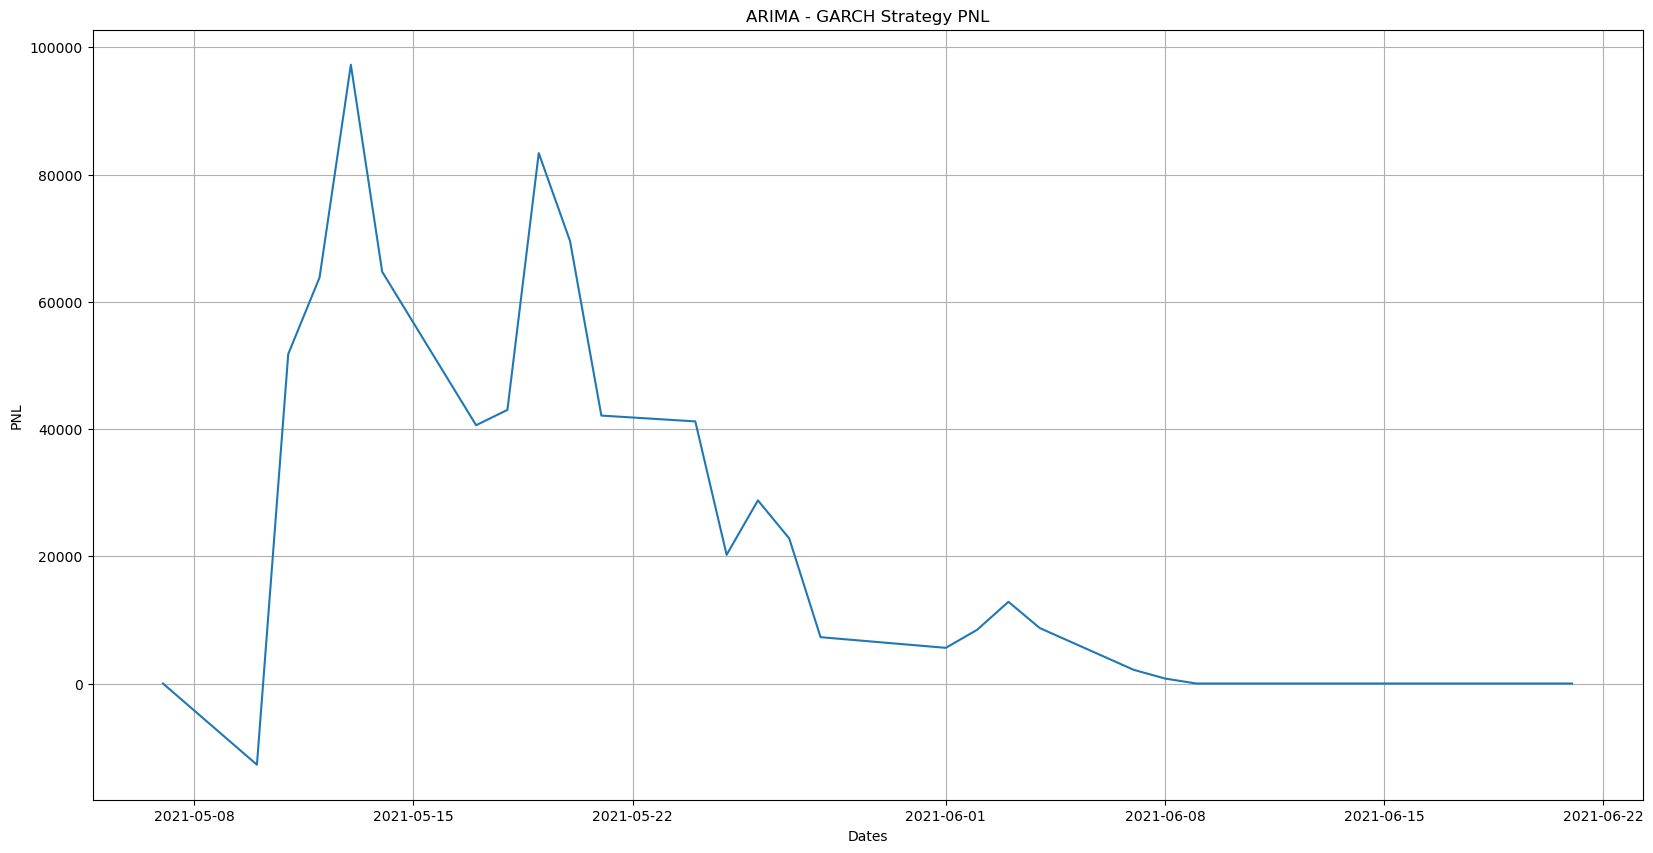

In [92]:
#Plotting GARCH PNL
plt.figure(figsize=(20, 10))
plt.grid()
plt.title('ARIMA - GARCH Strategy PNL')
plt.xlabel('Dates')
plt.ylabel('PNL')
plt.plot(Dates, GARCH_PNL)
plt.show()

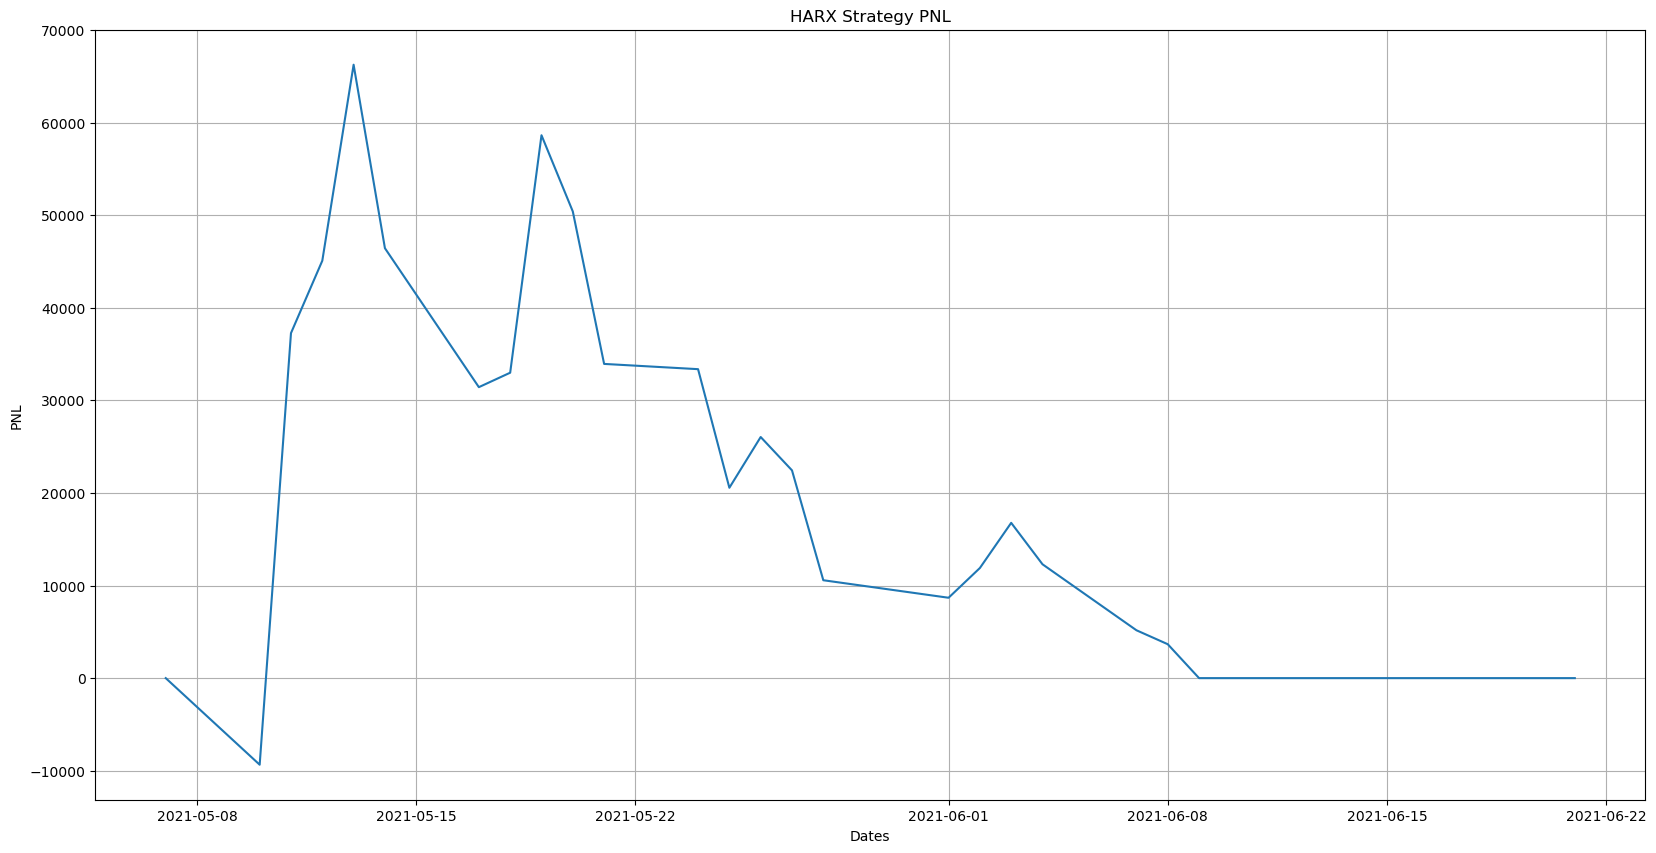

In [93]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.title('HARX Strategy PNL')
plt.xlabel('Dates')
plt.ylabel('PNL')
plt.plot(Dates, HARX_PNL)
plt.show()